In [1]:
import os
import sys
import time
import datetime

import numpy as np
import pandas as pd
import collections
import scipy
import scipy.io
import scipy.stats
import mat73

import matplotlib.pyplot as plt
import seaborn as sns
from skimage import data, img_as_float
from numpy import linalg as LA
from pandas import Series
import pandas.core.algorithms as algos

from sklearn.preprocessing import (
    MultiLabelBinarizer, LabelBinarizer, LabelEncoder, 
    StandardScaler, MinMaxScaler, OneHotEncoder
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, precision_recall_fscore_support, 
    roc_auc_score, mean_squared_error, mean_absolute_error, 
    median_absolute_error, r2_score
)

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras import layers, initializers, backend as K, regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import (
    Embedding, Dense, Dropout, Reshape, BatchNormalization, 
    TimeDistributed, Lambda, Activation, LSTM, GRU, Flatten, 
    Convolution1D, MaxPooling1D, concatenate, Conv2D, 
    MaxPooling2D, Conv3D, MaxPooling3D, dot, Permute, 
    Concatenate, add, LeakyReLU
)

import hosvd
from scipy.io import loadmat, savemat
#os.environ['CUDA_VISIBLE_DEVICES'] = ''


In [2]:
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-10
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(epsilon,np.abs(y_true)))) * 100

In [4]:
def smape(A, F):
    return ((100.0/len(A)) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F))+ np.finfo(float).eps))

In [5]:
# Relative root mean square error
def RRMSE (real, predicted):
  a = np.linalg.norm((real-predicted), ord='fro')
  b = np.linalg.norm(real, ord='fro')
  return(a/b)

In [6]:

file_type = input("Enter file type (.npy or .mat): ").strip()

file_path = input("Enter the file path: ").strip()

if file_type == '.npy':
    tensorOrig1 = np.load(file_path)
elif file_type == '.mat':
    tensorOrig1 = mat73.loadmat(file_path)['Tensor']
else:
    raise ValueError("Unsupported file type. Please provide a .npy or .mat file.")

print(f"Original Tensor shape: {tensorOrig1.shape}")

total_slices = tensorOrig1.shape[-1]
print(f"The dataset contains {total_slices} temporal snapshots.")
temporal_range = input(
    f"Enter the range of temporal snapshots to consider (e.g., '100-200' or '300-{total_slices}'): "
).strip()

try:
    start, end = map(int, temporal_range.split('-'))
    if start < 1 or end > total_slices or start > end:
        raise ValueError
except ValueError:
    raise ValueError(f"Invalid range. Please specify a valid range between 1 and {total_slices}.")

Ten_orig = tensorOrig1[..., start - 1:end] 

Enter file type (.npy or .mat):  .npy
Enter the file path:  Re130_u.npy


Original Tensor shape: (2, 100, 100, 500)
The dataset contains 500 temporal snapshots.


Enter the range of temporal snapshots to consider (e.g., '100-200' or '300-500'):  1-500


In [9]:
# Reshape the matrix in order to recover the original tensor
Mat_orig = np.reshape(np.copy(Ten_orig), [np.product(Ten_orig.shape[:-1]), Ten_orig.shape[-1]], order = 'F')
Mat_orig.shape

(20000, 500)

In [10]:
U, S, V = np.linalg.svd(Mat_orig, full_matrices=False)

Modes = 10

S = np.diag(S)

U = U[:,0:Modes]
S = S[0:Modes,0:Modes]
V = V[0:Modes,:]

In [11]:
AML = np.dot(S,V) 
tensor = AML

In [12]:
AML_train = AML[:, :400]
# Select next 100 snapshots for development
AML_dev = AML[:, 400:500]

print(f"AML Train Set Shape: {AML_train.shape}")
print(f"AML Development Set Shape: {AML_dev.shape}")

AML Train Set Shape: (10, 400)
AML Development Set Shape: (10, 100)


In [13]:
tensor = np.concatenate([np.copy(AML_train), np.copy(AML_dev)], axis = 1)
tensor_test = np.copy(AML_dev)

In [14]:
# min, max, range and standard deviation of values
min_val = np.amin(tensor)
max_val = np.amax(tensor)
range_val = np.ptp(tensor)
std_val =np.std(tensor)
mean_val = np.mean(tensor)
print(min_val, max_val)
print(range_val) # value range
print(std_val)

# Quantiles of data
np.quantile(tensor.flatten(), np.arange(0,1,0.1))

tensor_norm = (tensor-min_val)/range_val
tensor_test_norm = (tensor_test-min_val)/range_val
scipy.stats.describe(tensor_norm.flatten())

total_length = tensor_norm.shape[1] 
channels_n = 0                      
dim_x = tensor_norm.shape[0]       
dim_y = 0                           

print('total_length: ', total_length)
print('channels_n: ', channels_n)
print('dim_x: ', dim_x)
print('dim_y: ', dim_y)

-98.56224365389745 14.437676588274254
112.99992024217171
29.923121791159428
total_length:  500
channels_n:  0
dim_x:  10
dim_y:  0


In [15]:
class SequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, list_IDs, batch_size=5, seq_len=1, horizon=1, shuffle=True, till_end=False, only_test=False):
        self.data = data
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.horizon = horizon
        self.till_end = till_end
        self.only_test = only_test
        self.on_epoch_end()

    def __len__(self):
        if self.till_end:
            return math.ceil(len(self.list_IDs) / self.batch_size)
        else:
            return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        if self.only_test:
            return X
        else:
            return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, self.seq_len, self.data.shape[0]))
        y_inter = np.empty((self.batch_size, self.horizon, self.data.shape[0]))

        for i, ID in enumerate(list_IDs_temp):
            X[i, :, :] = self.data[:, ID:ID + self.seq_len].T
            y_inter[i, :, :] = self.data[:, ID + self.seq_len:ID + self.seq_len + self.horizon].T

        y = [y_inter[:, h, :] for h in range(self.horizon)]
        return X, y
        y = [y_inter[:, h, :] for h in range(self.horizon)]
        return X, y
        y = [y_inter[:, :, j].reshape(self.batch_size, -1) for j in range(self.p)]
        return X.transpose((0, 2, 1)), y
        y = [y_inter[:, :, j].reshape(self.batch_size, -1) for j in range(self.p)]
        return X.transpose((0, 2, 1)), y

In [16]:
def create_model(in_shape, out_dim, horizon=1, shared_dim=128, alpha=0.01, learning_rate=0.001):
    x = Input(shape=in_shape)

    # LSTM layer
    v = LSTM(128, return_sequences=False)(x)
    w = Dense(64, activation=LeakyReLU(alpha=alpha))(v)

    # Output layer without reshaping
    v = Dense(out_dim, activation='linear')(w)

    model = Model(inputs=x, outputs=v, name='Temporal_forecasting')
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mae'])

    return model

###### ADDED HYPERTUNNING TO BE USED IF REQUIRED. ELSE; JUST USE THE VALUES FROM HOSVD ########

In [17]:
from keras_tuner import BayesianOptimization
def run_bayesian_optimization(tensor_norm, tensor_test_norm, AML_dev, AML_train, dim_x):
    def build_model(hp):
        seq_len = hp.Int('seq_len', min_value=5, max_value=15, step=5)
        batch_size = hp.Int('batch_size', min_value=4, max_value=32, step=4)
        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
        
        in_shape = (seq_len, dim_x)
        out_dim = dim_x
        model = create_model(in_shape, out_dim, horizon=1, shared_dim=128,  learning_rate=learning_rate)
        return model

    tuner = BayesianOptimization(
        build_model,
        objective='val_loss',
        max_trials=20,
        directory='bayesian_optimizationnew',
        project_name='lstm_hyperopthorizon no dense new'
    )

    # Define data generators for training
    train_gen = SequenceGenerator(tensor_norm, np.arange(AML_train.shape[1]), batch_size=10, seq_len=50, horizon=1, shuffle=True)
    val_gen = SequenceGenerator(tensor_norm, np.arange(AML_dev.shape[1]), batch_size=10, seq_len=50, horizon=1, shuffle=False)

    tuner.search(train_gen, validation_data=val_gen, epochs=20)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    return best_hps

# Hyperparameter search example
best_hps = run_bayesian_optimization(tensor_norm, tensor_test_norm, AML_dev, AML_train, dim_x)
print(f"Best hyperparameters: seq_len={best_hps.get('seq_len')}, batch_size={best_hps.get('batch_size')}, learning_rate={best_hps.get('learning_rate')}")


Reloading Tuner from bayesian_optimizationnew\lstm_hyperopthorizon no dense new\tuner0.json
Best hyperparameters: seq_len=10, batch_size=16, learning_rate=0.00029973497945481897


In [18]:
# Get test, val, and train lengths
test_length = AML_dev.shape[-1]
val_length  = AML_dev.shape[1]
train_length = AML_train.shape[1]
best_seq_len = best_hps.get('seq_len')
best_batch_size = best_hps.get('batch_size')

train_generator = SequenceGenerator(
    tensor_norm, np.arange(AML_train.shape[1]),
    batch_size=best_batch_size,seq_len=best_seq_len, horizon=1, shuffle=True
)

validation_generator = SequenceGenerator(
    tensor_norm, np.arange(AML_dev.shape[1]),
    batch_size=best_batch_size, seq_len=best_seq_len, horizon=1, shuffle=False
)

test_generator = SequenceGenerator(
    tensor_test_norm, np.arange(tensor_test_norm.shape[1]),
    batch_size=best_batch_size, seq_len=best_seq_len, horizon=1, only_test=True, shuffle=False
)

for batch in validation_generator:
    input_nn, target_nn = batch
    break

print(len(input_nn))
print(input_nn[0].shape)
print(len(target_nn))
print(target_nn[0].shape)

16
(10, 10)
1
(16, 10)


In [19]:
# Create and summarize the model
model = create_model(in_shape=(best_seq_len, dim_x), out_dim=dim_x, horizon=1, learning_rate=best_hps.get('learning_rate'))
model.summary()

Model: "Temporal_forecasting"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 10)]          0         
                                                                 
 lstm (LSTM)                 (None, 128)               71168     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 80,074
Trainable params: 80,074
Non-trainable params: 0
_________________________________________________________________


In [20]:
save_string = 'saved_weights'

# save the best weights
save_best_weights = save_string + '.h5'
save_summary_stats = save_string + '.csv'
save_last_weights = save_string + '_last_w.h5'
save_results_metrics = save_string + '_results_metrics.csv'


In [21]:
np.random.seed(247531338)
tf.random.set_seed(31722973)


callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='auto'),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
]

num_epochs = 250
history = model.fit(train_generator, validation_data=validation_generator, epochs=num_epochs, verbose=1, callbacks=callbacks)


Epoch 1/250
25/25 [==============================] - 2s 26ms/step - loss: 0.1244 - mae: 0.2429 - val_loss: 0.0033 - val_mae: 0.0462
Epoch 2/250
25/25 [==============================] - 0s 6ms/step - loss: 0.0030 - mae: 0.0400 - val_loss: 0.0021 - val_mae: 0.0300
Epoch 3/250
25/25 [==============================] - 0s 6ms/step - loss: 0.0018 - mae: 0.0248 - val_loss: 0.0018 - val_mae: 0.0232
Epoch 4/250
25/25 [==============================] - 0s 6ms/step - loss: 0.0017 - mae: 0.0224 - val_loss: 0.0017 - val_mae: 0.0218
Epoch 5/250
25/25 [==============================] - 0s 6ms/step - loss: 0.0017 - mae: 0.0224 - val_loss: 0.0016 - val_mae: 0.0220
Epoch 6/250
25/25 [==============================] - 0s 5ms/step - loss: 0.0017 - mae: 0.0220 - val_loss: 0.0017 - val_mae: 0.0233
Epoch 7/250
25/25 [==============================] - 0s 5ms/step - loss: 0.0017 - mae: 0.0230 - val_loss: 0.0017 - val_mae: 0.0223
Epoch 8/250
25/25 [==============================] - 0s 6ms/step - loss: 0.0017 - 

In [22]:
# Aggregate the summary statistics
summary_stats = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                              'train_loss': history.history['loss'],
                              'val_loss': history.history['val_loss']})

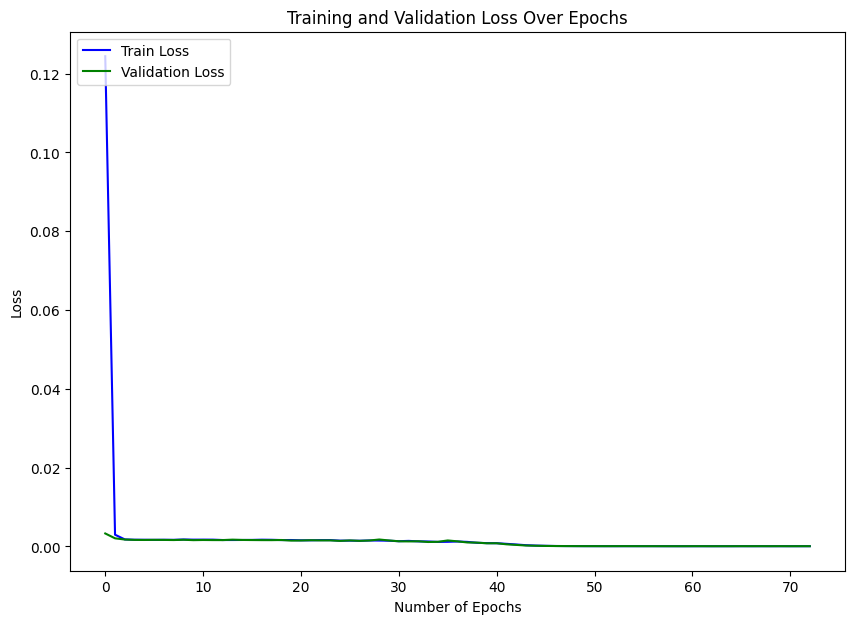

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(summary_stats.train_loss, 'b', label='Train Loss')
ax.plot(summary_stats.val_loss, 'g', label='Validation Loss')
ax.set_xlabel('Number of Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss Over Epochs')
ax.legend(loc='upper left')

plt.show()

In [24]:
min_loss, idx = min((loss, idx) for (idx, loss) in enumerate(history.history['val_loss']))
print('Minimum val_loss at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(min_loss))
min_loss = round(min_loss, 4)

Minimum val_loss at epoch 63 = 0.0001


In [25]:
def evaluate_model_test_iter(ten_orig_1, time_pred, inputWidth):
    ten_orig = np.copy(ten_orig_1)
    
    if len(Ten_orig.shape) == 4:  # 4D tensor
        predictions = np.empty((ten_orig.shape[0], time_pred))
    elif len(Ten_orig.shape) == 5:  # 5D tensor
        predictions = np.empty((ten_orig.shape[0], time_pred))
    else:
        raise ValueError("Unsupported tensor shape. Expected 4D or 5D.")    
    snap = np.copy(ten_orig[..., -inputWidth:])
    snap = np.transpose(snap, [1, 0])
    snap = snap[None, ...]
    print(snap.shape)

    for i in range(time_pred):
        pred = model.predict(snap, verbose=0)
        pred = np.array(pred)
        
        if len(pred.shape) == 2:
            pred = pred[:, None, :]

        pred = np.transpose(pred, [1, 0, 2])

        # Standardization inverse transformation
        pred_1 = np.copy(pred[0, :, :]) * range_val + min_val
        
        if len(predictions.shape) == 2:  # 4D tensor case
            predictions[..., i] = pred_1
        elif len(predictions.shape) == 3:  # 5D tensor case
            predictions[..., i] = pred_1

        # Concatenate the new prediction with the previous input
        snap = np.concatenate([snap[:, 1:, :], pred], axis=1)

    # Clean up memory
    del ten_orig, snap, pred, pred_1

    return predictions



t0 = time.time()

time_pred = 90  
inputWidth = best_hps['seq_len']  

predictions = evaluate_model_test_iter(tensor_norm[:, :-100], time_pred=time_pred, inputWidth=inputWidth)
target_start = int(input("Enter the starting index for targets (e.g., 400): ").strip())
# Assign targets based on tensor shape
if len(tensorOrig1.shape) == 4:
    targets = tensorOrig1[:, :, :, target_start:target_start + time_pred]
elif len(tensorOrig1.shape) == 5:
    targets = tensorOrig1[:, :, :, :, target_start:target_start + time_pred]

t1 = time.time()

print(f"Time taken: {t1 - t0} seconds")
print(f"Predictions shape: {predictions.shape}")

(1, 10, 10)


Enter the starting index for targets (e.g., 400):  400


Time taken: 6.186380624771118 seconds
Predictions shape: (10, 90)


In [26]:
import numpy as np
A_d_flat = np.dot(U, predictions)  
if tensorOrig1.ndim == 4:  # Case for 4D tensor
    original_shape = (tensorOrig1.shape[0], tensorOrig1.shape[1], tensorOrig1.shape[2], time_pred)
elif tensorOrig1.ndim == 5:  # Case for 5D tensor
    original_shape = (tensorOrig1.shape[0], tensorOrig1.shape[1], tensorOrig1.shape[2], tensorOrig1.shape[3],  time_pred)
else:
    raise ValueError("Unsupported tensor dimensionality. Expected 4D or 5D tensor.")

A_d = np.reshape(A_d_flat, original_shape, order='F')
print(f"Reconstructed tensor shape: {A_d.shape}")

Reconstructed tensor shape: (2, 100, 100, 90)


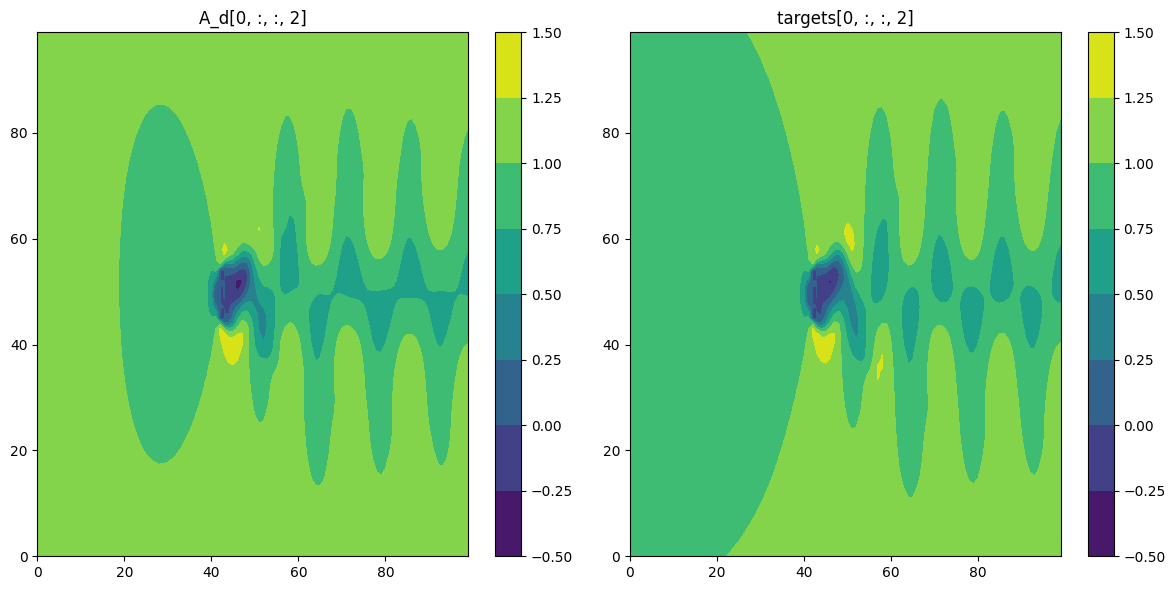

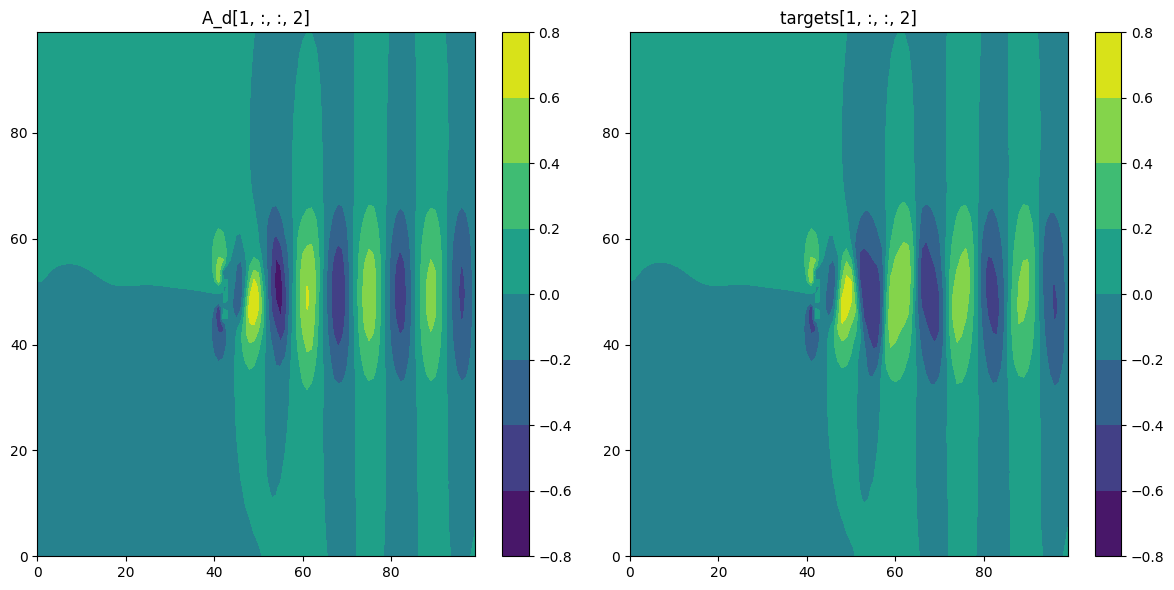

In [27]:
def plot_tensors(A_d, targets, velocity_components, time_index):   
    if A_d.ndim not in [4, 5] or targets.ndim not in [4, 5]:
        raise ValueError("Input tensors must be 4D or 5D.")    
    if A_d.shape != targets.shape:
        raise ValueError("Shape of A_d and targets must match.") 
        
    for comp in range(velocity_components):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
       
        contour_pred = axs[0].contourf(
            A_d[comp, :, :, 0, time_index] if A_d.ndim == 5 else A_d[comp, :, :, time_index],
            cmap='viridis'
        )
        axs[0].set_title(f'A_d[{comp}, :, :, 0, {time_index}]' if A_d.ndim == 5 else f'A_d[{comp}, :, :, {time_index}]')
        fig.colorbar(contour_pred, ax=axs[0], orientation='vertical')
        
        contour_target = axs[1].contourf(
            targets[comp, :, :, 0, time_index] if targets.ndim == 5 else targets[comp, :, :, time_index],
            cmap='viridis'
        )
        axs[1].set_title(f'targets[{comp}, :, :, 0, {time_index}]' if targets.ndim == 5 else f'targets[{comp}, :, :, {time_index}]')
        fig.colorbar(contour_target, ax=axs[1], orientation='vertical')        
        plt.tight_layout()        
        plt.show()

time_index = 2 
velocity_components = 2  
plot_tensors(A_d, targets, velocity_components, time_index)
